In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pickle as pkl
import numpy as np

In [4]:
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, RidgeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBClassifier
from sklearn.preprocessing import Normalizer
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix

In [5]:
data = pd.read_csv("Train.csv")


In [9]:
data.head()

,ID,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
0,1,D,Flight,4,2,177,3,low,F,44,1233,1
1,2,F,Flight,4,5,216,2,low,M,59,3088,1
2,3,A,Flight,2,2,183,4,low,M,48,3374,1
3,4,B,Flight,3,3,176,4,medium,M,10,1177,1
4,5,C,Flight,2,2,184,3,medium,F,46,2484,1


In [10]:
data.shape

(10999, 12)

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10999 entries, 0 to 10998
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ID                   10999 non-null  int64 
 1   Warehouse_block      10999 non-null  object
 2   Mode_of_Shipment     10999 non-null  object
 3   Customer_care_calls  10999 non-null  int64 
 4   Customer_rating      10999 non-null  int64 
 5   Cost_of_the_Product  10999 non-null  int64 
 6   Prior_purchases      10999 non-null  int64 
 7   Product_importance   10999 non-null  object
 8   Gender               10999 non-null  object
 9   Discount_offered     10999 non-null  int64 
 10  Weight_in_gms        10999 non-null  int64 
 11  Reached.on.Time_Y.N  10999 non-null  int64 
dtypes: int64(8), object(4)
memory usage: 1.0+ MB


In [12]:
data.isnull().sum()

ID                     0
Warehouse_block        0
Mode_of_Shipment       0
Customer_care_calls    0
Customer_rating        0
Cost_of_the_Product    0
Prior_purchases        0
Product_importance     0
Gender                 0
Discount_offered       0
Weight_in_gms          0
Reached.on.Time_Y.N    0
dtype: int64

In [13]:
label_map={}

In [14]:
for i in data.columns:
    if str(data[i].dtype) == 'object':
        temp={}
        cats=data[i].unique()
        for index in range(len(cats)): 
            temp[cats [index]]=index 
            
        label_map[i]=temp
        #Labeling
        data[i]=data[i].map(temp)
label_map

{'Warehouse_block': {'D': 0, 'F': 1, 'A': 2, 'B': 3, 'C': 4},
 'Mode_of_Shipment': {'Flight': 0, 'Ship': 1, 'Road': 2},
 'Product_importance': {'low': 0, 'medium': 1, 'high': 2},
 'Gender': {'F': 0, 'M': 1}}

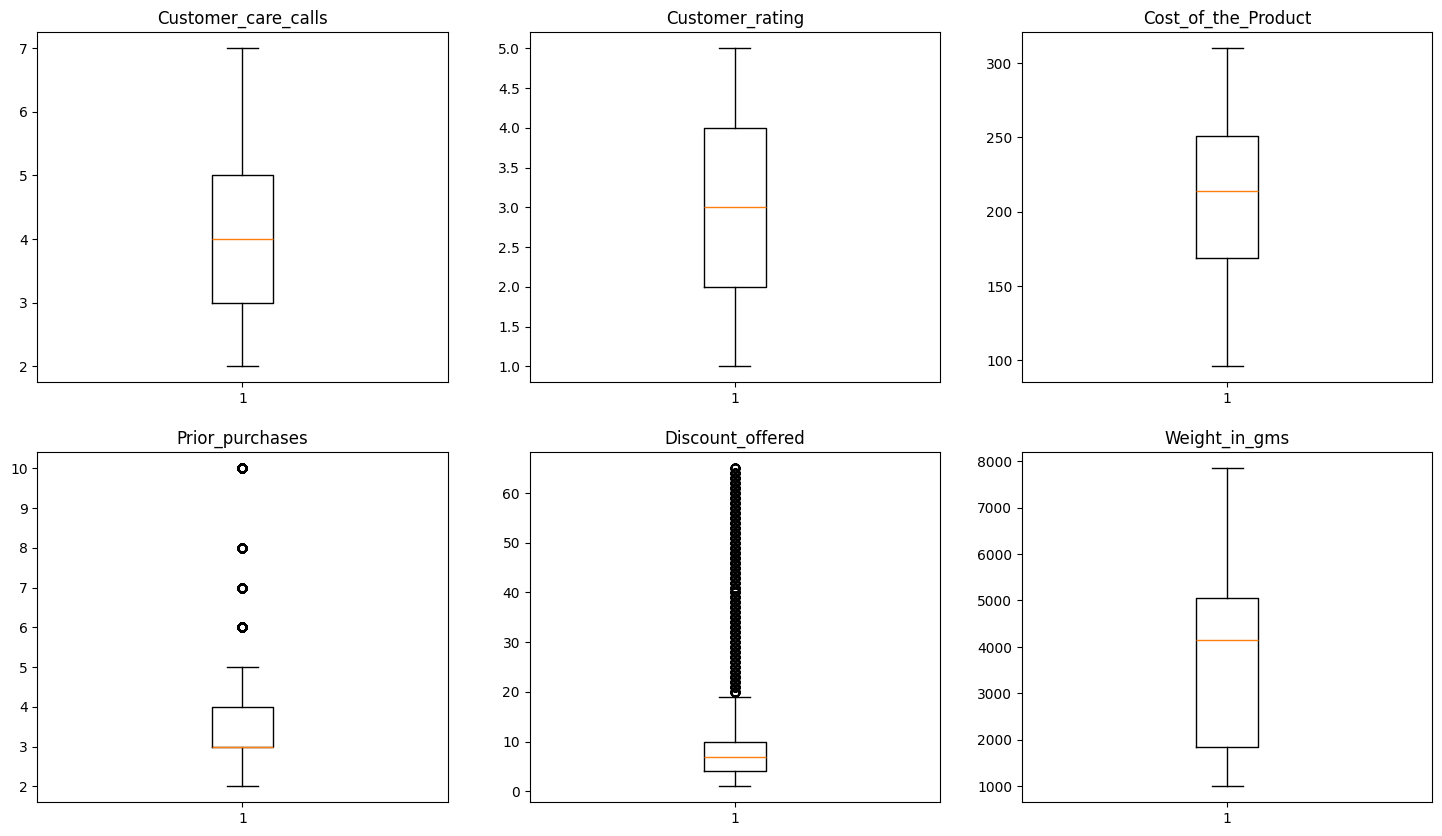

In [15]:
c=0
plt.figure(figsize=(18, 10))
for i in data.drop(columns=[ 'Warehouse_block', 'Mode_of_Shipment', 'Product_importance', 'Gender', 'Reached.on.Time_Y.N', 'ID' ]).columns:
    if str(data[i].dtype)=='object':
        continue
    plt.subplot(2, 3, c+1)
    plt.boxplot(data[i])
    plt.title(i)
    c+=1
plt.show()

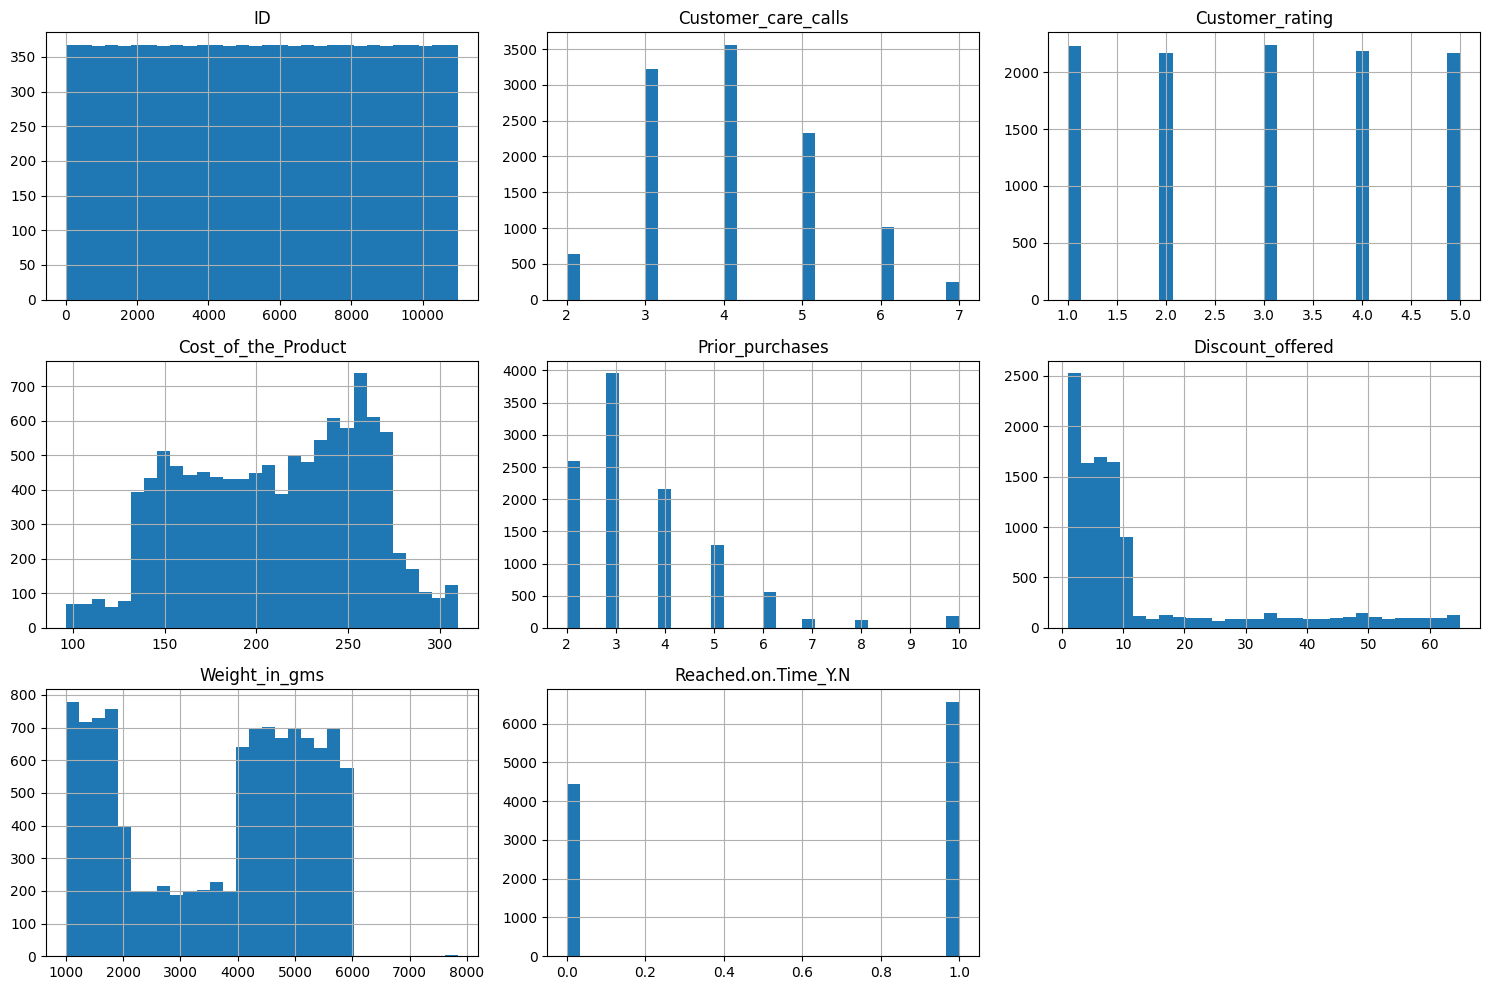

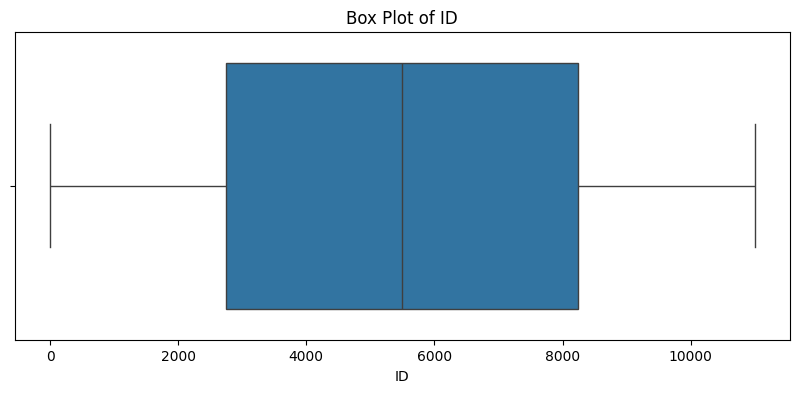

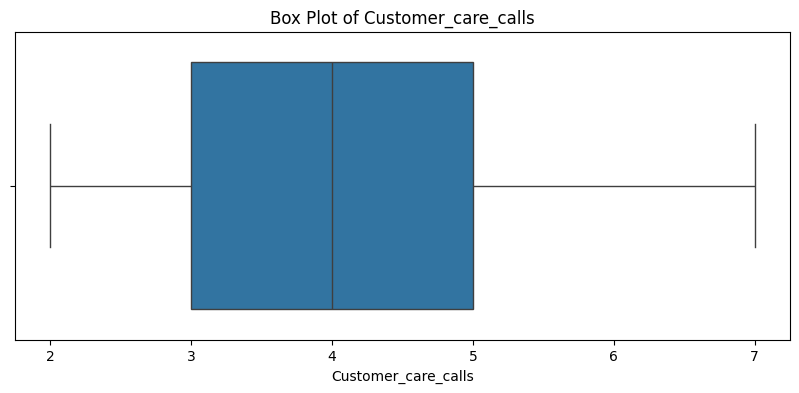

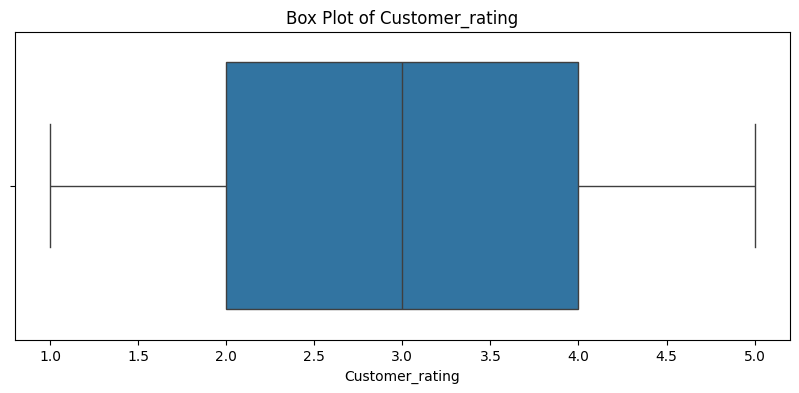

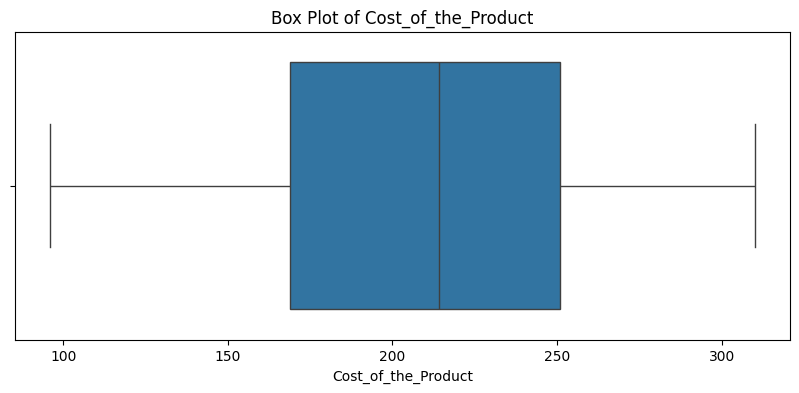

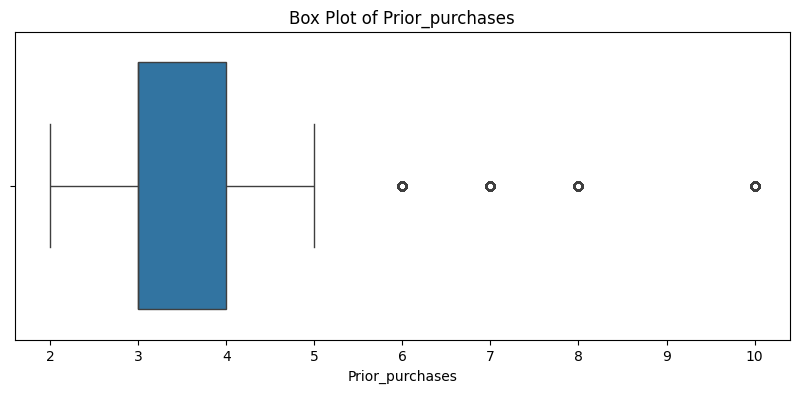

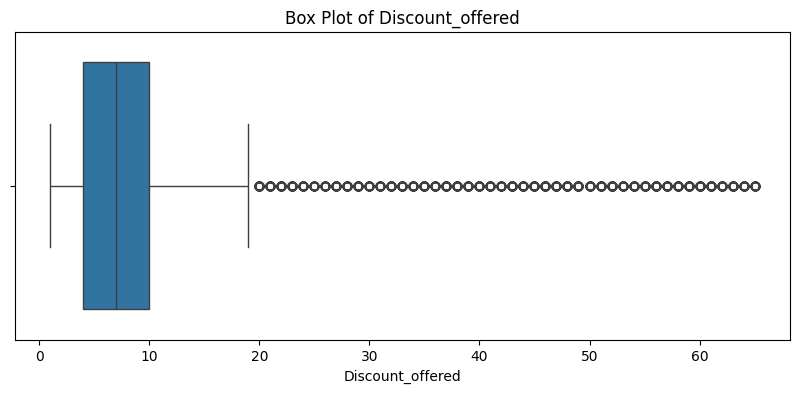

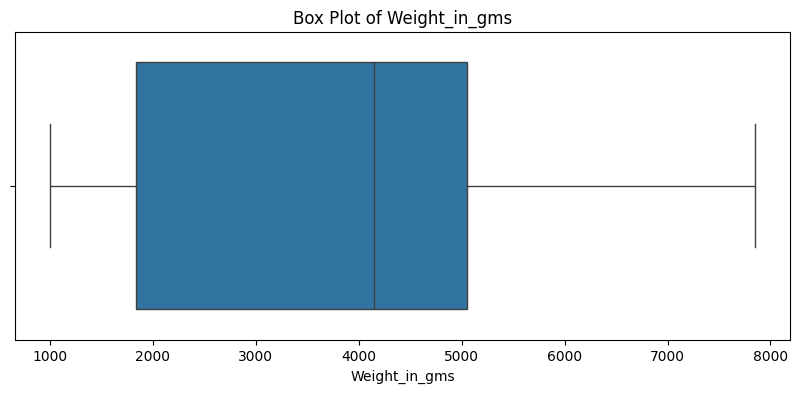

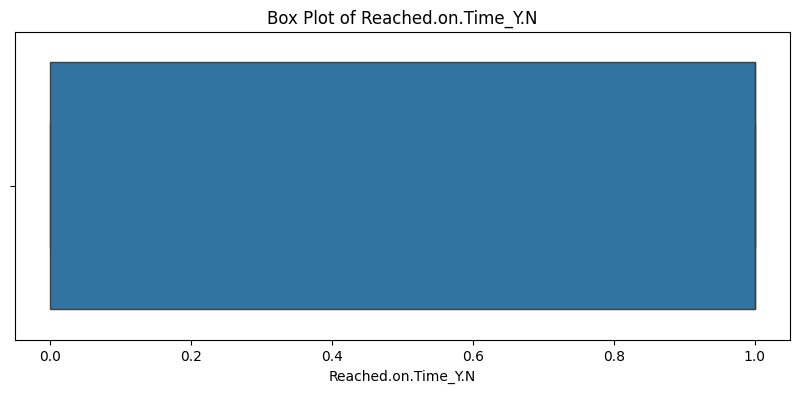

In [6]:
# List of numerical columns
numerical_cols = data.select_dtypes(include=['float64', 'int64']).columns

# Plot histograms for numerical columns
data[numerical_cols].hist(bins=30, figsize=(15, 10), layout=(len(numerical_cols) // 3 + 1, 3))
plt.tight_layout()
plt.show()

# Plot box plots for numerical columns
for col in numerical_cols:
    plt.figure(figsize=(10, 4))
    sns.boxplot(x=data[col])
    plt.title(f'Box Plot of {col}')
    plt.show()


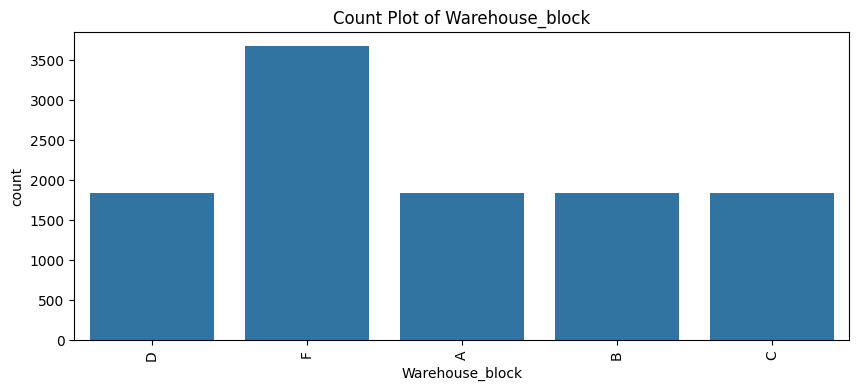

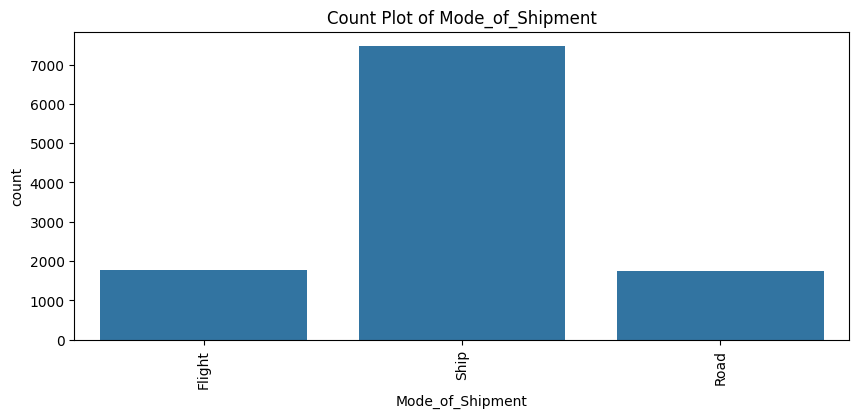

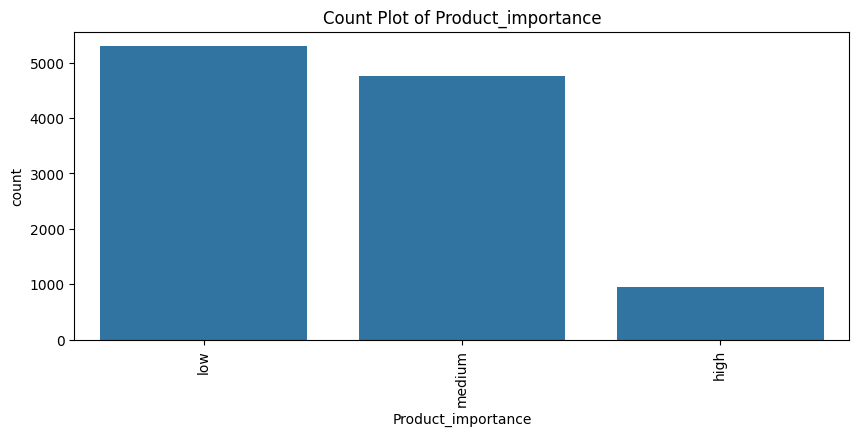

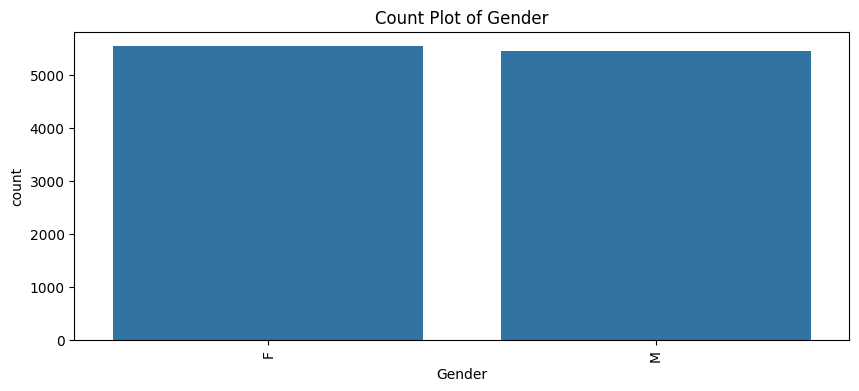

In [8]:
# List of categorical columns
categorical_cols = data.select_dtypes(include=['object']).columns

# Plot bar plots for categorical columns
for col in categorical_cols:
    plt.figure(figsize=(10, 4))
    sns.countplot(x=data[col])
    plt.title(f'Count Plot of {col}')
    plt.xticks(rotation=90)
    plt.show()


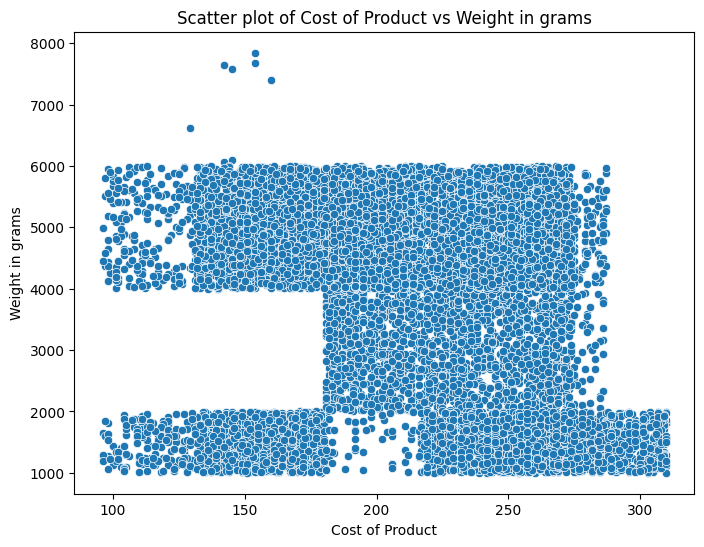

In [11]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Cost_of_the_Product', y='Weight_in_gms', data=data)
plt.title('Scatter plot of Cost of Product vs Weight in grams')
plt.xlabel('Cost of Product')
plt.ylabel('Weight in grams')
plt.show()

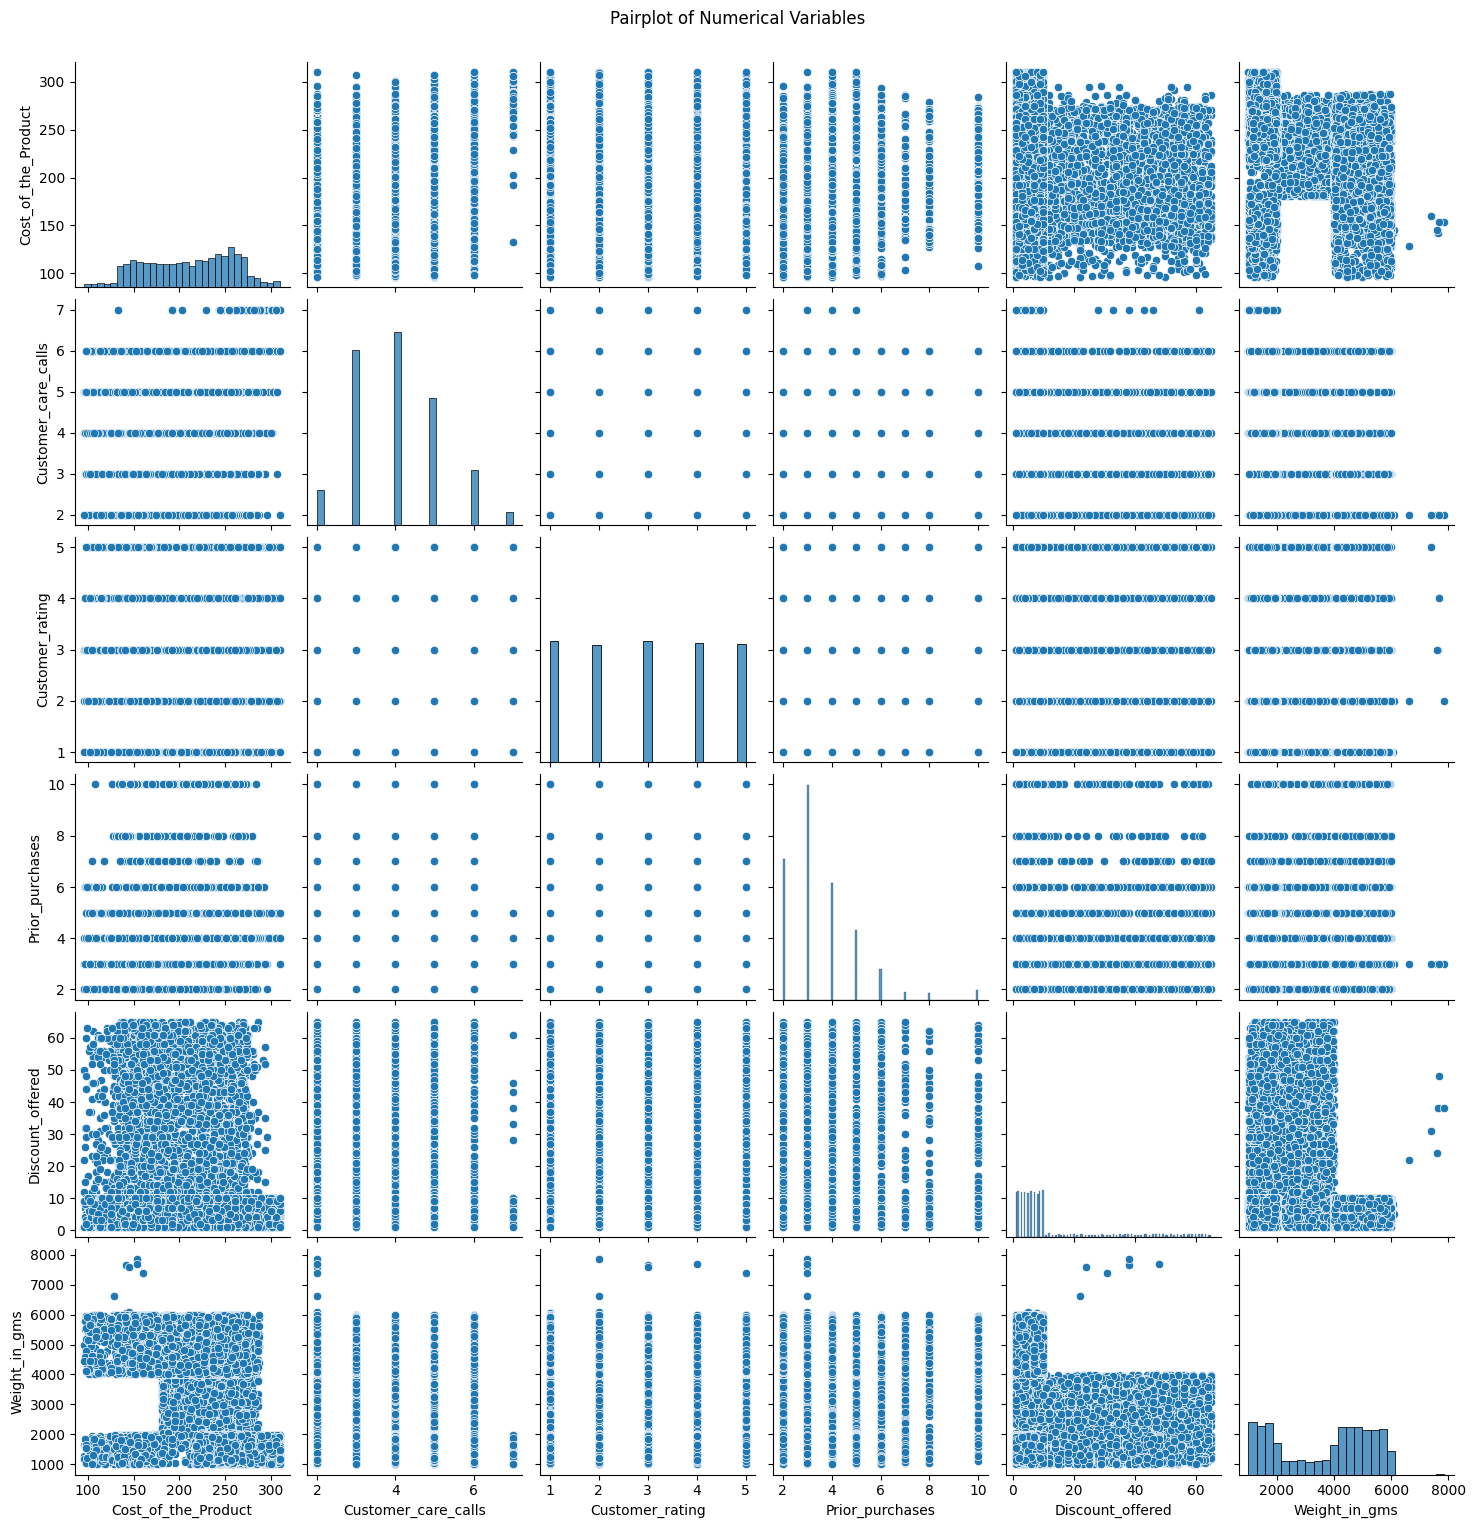

In [12]:
numerical_cols = ['Cost_of_the_Product', 'Customer_care_calls', 'Customer_rating', 'Prior_purchases', 'Discount_offered', 'Weight_in_gms']

# Create pairplot
sns.pairplot(data[numerical_cols])
plt.suptitle('Pairplot of Numerical Variables', y=1.02)
plt.show()

In [16]:
data.isnull().sum()

ID                     0
Warehouse_block        0
Mode_of_Shipment       0
Customer_care_calls    0
Customer_rating        0
Cost_of_the_Product    0
Prior_purchases        0
Product_importance     0
Gender                 0
Discount_offered       0
Weight_in_gms          0
Reached.on.Time_Y.N    0
dtype: int64

In [17]:
def check_outliers (arr):
    Q1 = np.percentile (arr, 25, interpolation = 'midpoint') 
    Q3= np.percentile (arr, 75, interpolation = 'midpoint')
    IQR=Q3-Q1
    #Above Upper bound
    upper=Q3+1.5*IQR
    upper_array=np.array(arr>=upper)
    print(' '*3,len(upper_array [upper_array == True]), 'are over the upper bound:', upper)
    #Below Lower bound
    lower=Q1-1.5*IQR
    lower_array=np.array(arr<=lower)
    print(' '*3,len(lower_array[lower_array == True]), 'are less than the lower bound:', lower, '\n')
for i in data.drop(columns=[ 
                            'Warehouse_block', 'Mode_of_Shipment', 'Product_importance', 'Gender', 'Reached.on.Time_Y.N', 'ID' 
                            ]).columns:
        if str(data[i].dtype)=='object':
            continue
        print(i)
        check_outliers (data[i])

Customer_care_calls
    0 are over the upper bound: 8.0
    0 are less than the lower bound: 0.0 

Customer_rating
    0 are over the upper bound: 7.0
    0 are less than the lower bound: -1.0 

Cost_of_the_Product
    0 are over the upper bound: 374.0
    0 are less than the lower bound: 46.0 

Prior_purchases
    1003 are over the upper bound: 5.5
    0 are less than the lower bound: 1.5 

Discount_offered
    2262 are over the upper bound: 19.0
    0 are less than the lower bound: -5.0 

Weight_in_gms
    0 are over the upper bound: 9865.75
    0 are less than the lower bound: -2976.25 



C:\Users\Arjun\AppData\Local\Temp\ipykernel_19744\2307631936.py:19: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  check_outliers (data[i])


In [18]:
data.describe(include='all')

,ID,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
count,10999.00000,10999.000000,10999.000000,10999.000000,10999.000000,10999.000000,10999.000000,10999.000000,10999.000000,10999.000000,10999.000000,10999.000000
mean,5500.00000,1.833167,0.998454,4.054459,2.990545,210.196836,3.567597,0.604600,0.495863,13.373216,3634.016729,0.596691
std,3175.28214,1.343823,0.567099,1.141490,1.413603,48.063272,1.522860,0.641464,0.500006,16.205527,1635.377251,0.490584
min,1.00000,0.000000,0.000000,2.000000,1.000000,96.000000,2.000000,0.000000,0.000000,1.000000,1001.000000,0.000000
25%,2750.50000,1.000000,1.000000,3.000000,2.000000,169.000000,3.000000,0.000000,0.000000,4.000000,1839.500000,0.000000
50%,5500.00000,1.000000,1.000000,4.000000,3.000000,214.000000,3.000000,1.000000,0.000000,7.000000,4149.000000,1.000000
75%,8249.50000,3.000000,1.000000,5.000000,4.000000,251.000000,4.000000,1.000000,1.000000,10.000000,5050.000000,1.000000
max,10999.00000,4.000000,2.000000,7.000000,5.000000,310.000000,10.000000,2.000000,1.000000,65.000000,7846.000000,1.000000


<Axes: >

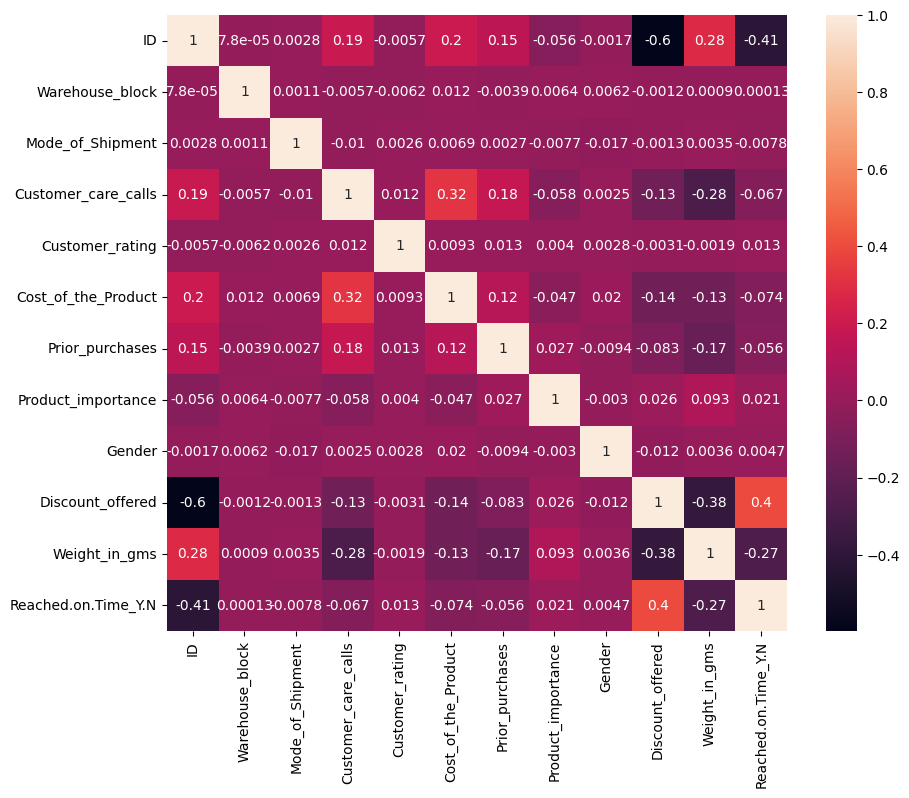

In [19]:
plt.figure(figsize=(10,8))
hm=data.corr(numeric_only=True)
sns.heatmap(hm,annot=True)

In [20]:
x_train,x_test,y_train,y_test=train_test_split(data.drop(columns=['ID', 'Reached.on.Time_Y.N']),data['Reached.on.Time_Y.N'],random_state=1234, test_size = 0.20,shuffle=True)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(8799, 10)
(2200, 10)
(8799,)
(2200,)


In [21]:
def models_eval_mm(x_train,y_train, x_test,y_test): 
    lg=LogisticRegression (random_state=1234)
    lg.fit(x_train, y_train)
    print('--Logistic Regression')
    print('Train Score:', lg.score(x_train, y_train)) 
    print('Test Score:',lg.score(x_test,y_test))
    print()
    lcv= LogisticRegressionCV (random_state=1234) 
    lcv.fit(x_train,y_train)
    print("--Logistic Regression CV")
    print("Train Score:",lcv.score(x_train,y_train))
    print()
    print('Test Score:',lcv.score(x_test,y_test))
    print('--XGBoost')
    xgb = XGBClassifier(random_state=1234) 
    xgb.fit(x_train,y_train)
    print('Train Score:', xgb.score(x_train,y_train))
    print('Test Score:xgb',xgb.score(x_test,y_test))
    print()
    print('--Ridge Classifier') 
    rg = RidgeClassifier(random_state=1234) 
    rg.fit(x_train,y_train)
    print('Train Score:', rg.score(x_train, y_train))
    print('Test Score:',rg.score(x_test,y_test))
    print()
    print('--KNN')
    knn = KNeighborsClassifier() 
    knn.fit(x_train,y_train)
    print('Train Score:',knn.score(x_train,y_train)) 
    print('Test Score:',knn.score(x_test,y_test))
    print()
    print('--Random Forest')
    rf = RandomForestClassifier(random_state=1234) 
    rf.fit(x_train,y_train)
    print('Train Score:', rf.score(x_train,y_train))
    print("Test Score:",rf.score(x_test,y_test))
    print()
    print('--SVM classifier')
    svc = svm.SVC(random_state=1234)
    svc.fit(x_train,y_train)
    print("Train Score:", svc.score(x_train,y_train))
    print("Test Score:",svc.score(x_test,y_test))
    print()
    return lg,lcv, xgb, rg, knn, rf, svc

In [22]:
normalizer=Normalizer()

In [23]:
x_train_normalized=pd.DataFrame(normalizer.fit_transform(x_train),columns=x_train.columns)
x_test_normalized=pd.DataFrame(normalizer.fit_transform(x_test), columns=x_test.columns)

In [24]:
lg, lcv, xgb, rg,knn, rf, svc=models_eval_mm(x_train_normalized, y_train,x_test_normalized,y_test)

--Logistic Regression
Train Score: 0.5976815547221275
Test Score: 0.5927272727272728

--Logistic Regression CV
Train Score: 0.6422320718263439

Test Score: 0.6409090909090909
--XGBoost
Train Score: 0.9362427548585066
Test Score:xgb 0.6681818181818182

--Ridge Classifier
Train Score: 0.5976815547221275
Test Score: 0.5927272727272728

--KNN
Train Score: 0.7756563245823389
Test Score: 0.6336363636363637

--Random Forest
Train Score: 1.0
Test Score: 0.6686363636363636

--SVM classifier
Train Score: 0.5976815547221275
Test Score: 0.5927272727272728



In [25]:
lg.predict(x_test_normalized.iloc[0].values.reshape(1, -1))

c:\Users\Arjun\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


array([1], dtype=int64)

In [26]:
def eval(name, model):
    y_pred=model.predict(x_test_normalized)
    result =[]
    result.append(name)
    result.append("{:.2f}".format(accuracy_score(y_test, y_pred)*100)) 
    result.append("{:.2f}".format(f1_score(y_test, y_pred)*100))
    result.append("{:.2f}".format(recall_score(y_test, y_pred)*100)) 
    result.append("{:.2f}".format(precision_score(y_test, y_pred)*100))
    return result
model_list={'logistic regression': lg, 
            'logistic regression CV':lcv,
            'XGBoost':xgb,
            'Ridge classifier':rg,
            "KNN":knn,
            "Random Forest":rf,
            "Support Vector Classifier":svc}
model_eval_info=[]
for i in model_list.keys(): 
    model_eval_info.append(eval(i,model_list[i]))
model_eval_info_df = pd.DataFrame(model_eval_info, columns=['Name', 'Accuracy', 'F1_Score', 'Recall', 'Precision'])

model_eval_info_df.to_csv("model_eval.csv", index=False)
from IPython.display import display, HTML

display(HTML(model_eval_info_df.to_html(index=False)))

Name,Accuracy,F1_Score,Recall,Precision
logistic regression,59.27,74.43,100.00,59.27
logistic regression CV,64.09,67.08,61.73,73.45
XGBoost,66.82,71.03,68.63,73.60
Ridge classifier,59.27,74.43,100.00,59.27
KNN,63.36,68.27,66.49,70.15
Random Forest,66.86,69.64,64.11,76.21
Support Vector Classifier,59.27,74.43,100.00,59.27


# HyperParameter Optimization

# SVM

In [27]:
import pandas as pd
from sklearn import svm
from sklearn.model_selection import GridSearchCV

# Define the SVM model
svc = svm.SVC(random_state=1234)

# Define the parameter grid
params = {
    'kernel': ['poly', 'rbf'],
    'C': [10, 13],
    'gamma': [4, 5],
    'tol': [1e-1, 1e-2, 1e-3]
}

# Initialize GridSearchCV
svc_cv = GridSearchCV(svc, param_grid=params, cv=5, refit=True, scoring="accuracy", n_jobs=-1, verbose=3)

# Fit the model
svc_cv.fit(x_train_normalized, y_train)

# Print the best estimator, parameters, and score
print("Best Estimator:", svc_cv.best_estimator_)
print("Best Parameters:", svc_cv.best_params_)
print("Best Score:", svc_cv.best_score_)


Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Estimator: SVC(C=13, gamma=5, random_state=1234, tol=0.01)
Best Parameters: {'C': 13, 'gamma': 5, 'kernel': 'rbf', 'tol': 0.01}
Best Score: 0.6676890278567368


In [28]:
svc = svm.SVC(random_state=1234)

params = {
    'kernel': ['poly', 'rbf'],
    'C': [10, 13],
    'gamma': [4, 5],
    'tol': [1e-1, 1e-2, 1e-3]
}

fitmodel = GridSearchCV(svc, param_grid=params, cv=5, refit=True, scoring="accuracy", n_jobs=-1, verbose=3)

fitmodel.fit(x_train_normalized, y_train)

print("Best Estimator:", fitmodel.best_estimator_)
print("Best Parameters:", fitmodel.best_params_)
print("Best Score:", fitmodel.best_score_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Estimator: SVC(C=13, gamma=5, random_state=1234, tol=0.01)
Best Parameters: {'C': 13, 'gamma': 5, 'kernel': 'rbf', 'tol': 0.01}
Best Score: 0.6676890278567368


# Logistic Regression

In [29]:
lg = LogisticRegressionCV(n_jobs=-1, random_state=1234)

lg_param_grid = {
    'Cs': [6, 8, 10, 15, 20],
    'max_iter': [60, 80, 100]
}

lg_cv = GridSearchCV(lg, param_grid=lg_param_grid, cv=5, scoring="accuracy", n_jobs=-1, verbose=3)

lg_cv.fit(x_train_normalized, y_train)

print("Best Score:", lg_cv.best_score_)
print("Best Parameters:", lg_cv.best_params_)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
Best Score: 0.6412089126053026
Best Parameters: {'Cs': 20, 'max_iter': 60}


# Random Forest

In [30]:
rf = RandomForestClassifier(random_state=1234)

rf_param_grid = {
    'n_estimators': [200, 300, 500],
    'criterion': ['entropy', 'gini'],
    'max_depth': [7, 8, 60, 80, 100],
    'max_features': ['auto', 'sqrt', 'log2']
}

rf_cv = GridSearchCV(rf, param_grid=rf_param_grid, cv=7, scoring="accuracy", n_jobs=-1, verbose=3)

rf_cv.fit(x_train_normalized, y_train)

print("Best Score:", rf_cv.best_score_)
print("Best Parameters:", rf_cv.best_params_)

Fitting 7 folds for each of 90 candidates, totalling 630 fits


c:\Users\Arjun\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
210 fits failed out of a total of 630.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
133 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Arjun\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Arjun\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "c:\Users\Arjun\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base

Best Score: 0.6801909307875896
Best Parameters: {'criterion': 'entropy', 'max_depth': 8, 'max_features': 'sqrt', 'n_estimators': 200}


# XGB

In [31]:
xgb = XGBClassifier(learning_rate=0.5, n_estimators=100, objective='binary:logistic', nthread=3)

# Define the parameter grid for XGBoost
params = {
    'min_child_weight': [10, 20],
    'gamma': [1.5, 2.0, 2.5],
    'colsample_bytree': [0.6, 0.8, 0.9],
    'max_depth': [4, 5, 6]
}

# Initialize GridSearchCV for XGBoost
fitmodel = GridSearchCV(xgb, param_grid=params, cv=5, refit=True, scoring="accuracy", n_jobs=-1, verbose=3)

# Fit the model using the normalized training data
fitmodel.fit(x_train_normalized, y_train)

# Print the best estimator, parameters, and score
print("Best Estimator:", fitmodel.best_estimator_)
print("Best Parameters:", fitmodel.best_params_)
print("Best Score:", fitmodel.best_score_)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best Estimator: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=2.0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.5, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=20, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None, nthread=3,
              num_parallel_tree=None, ...)
Best Parameters: {'colsample_bytree': 0.9, 'gamma': 2.0, 'max_depth': 4, 'min_child_weight': 20}
Best Score: 0.6763268127551811


# Ridge Classifier

In [32]:
ridge = RidgeClassifier()

# Define the parameter grid for Ridge Classifier
ridge_param_grid = {
    'alpha': [0.01, 0.1, 1, 10, 100],
    'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
}

# Initialize GridSearchCV
ridge_cv = GridSearchCV(ridge, ridge_param_grid, cv=7, scoring='accuracy', n_jobs=-1, verbose=3)

# Fit the model
ridge_cv.fit(x_train_normalized, y_train)

# Output the best score and parameters
print("Best Score: " + str(ridge_cv.best_score_))
print("Best Parameters: " + str(ridge_cv.best_params_))

Fitting 7 folds for each of 35 candidates, totalling 245 fits
Best Score: 0.6516649619274918
Best Parameters: {'alpha': 0.01, 'solver': 'sag'}


# KNN

In [33]:
knn = KNeighborsClassifier()

# Define the parameter grid for KNN
knn_param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

# Initialize GridSearchCV
knn_cv = GridSearchCV(knn, knn_param_grid, cv=7, scoring='accuracy', n_jobs=-1, verbose=3)

# Fit the model
knn_cv.fit(x_train_normalized, y_train)

# Output the best score and parameters
print("Best Score: " + str(knn_cv.best_score_))
print("Best Parameters: " + str(knn_cv.best_params_))

Fitting 7 folds for each of 30 candidates, totalling 210 fits
Best Score: 0.6537106489373793
Best Parameters: {'metric': 'euclidean', 'n_neighbors': 9, 'weights': 'distance'}


# SVC

# 

In [34]:
model_list = {
    'Logistic Regression': lg_cv,
    'Logistic Regression CV': lcv,
    'XGBoost': fitmodel,
    'Ridge Classifier': ridge_cv,
    'KNN': knn_cv,
    'Random Forest': rf_cv,
    'Support Vector Classifier': svc_cv
}

# Function to evaluate model performance
def eval(name, model):
    try:
        y_pred = model.predict(x_test_normalized)
        result = []
        result.append(name)
        result.append("{:.2f}".format(accuracy_score(y_test, y_pred) * 100))
        result.append("{:.2f}".format(f1_score(y_test, y_pred) * 100))
        result.append("{:.2f}".format(recall_score(y_test, y_pred) * 100))
        result.append("{:.2f}".format(precision_score(y_test, y_pred) * 100))
    except Exception as e:
        result = [name, "Not Fitted", "Not Fitted", "Not Fitted", "Not Fitted"]
        print(f"Error evaluating model {name}: {str(e)}")
    return result

# Evaluate each model and collect results
model_eval_info = []
for name, model in model_list.items():
    model_eval_info.append(eval(name, model))

# Create a DataFrame with evaluation results
model_eval_info_df = pd.DataFrame(model_eval_info, columns=['Name', 'Accuracy', 'F1_Score', 'Recall', 'Precision'])

# Display evaluation results
print("Model Evaluation Results:")
display(HTML(model_eval_info_df.to_html(index=False)))

# Save evaluation results to a CSV file
model_eval_info_df.to_csv("model_eval.csv", index=False)

Model Evaluation Results:


Name,Accuracy,F1_Score,Recall,Precision
Logistic Regression,63.95,66.97,61.66,73.29
Logistic Regression CV,64.09,67.08,61.73,73.45
XGBoost,67.36,68.40,59.59,80.27
Ridge Classifier,65.05,71.84,75.23,68.75
KNN,64.55,68.82,66.03,71.87
Random Forest,67.45,66.13,53.60,86.30
Support Vector Classifier,66.77,68.29,60.35,78.62
